
The data set contains 16 columns, 48895 unique values(samples). 

Variables
id: listing ID
name: name of the listing
host_id: host ID
host_name: name of the host
neighbourhood_group: location
neighbourhood: area
latitude: latitude coordinateslatitude: latitude coordinates
longitude: longitude coordinates
room_type: listing space type
price: price in dollars
minimum_nights: amount of nights minimum
number_of_reviews: number of reviews
last_review: latest review
reviews_per_month: number of reviews per month
calculated_host_listings_count: amount of listing per host
availability_365: number of days when listing is available for booking
link: https://www.kaggle.com/dgomonov/new-york-city--open-data



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime as dt
import seaborn as sns

# sklearn stuff
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#yellobrick stuff
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [24]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [25]:
def imply_season(month):
    return 'Summer' if month in [12, 1, 2] else 'Fall' if month in [3, 4, 5] else 'Spring' if month in [9, 10, 11] else 'Winter' 

def analyze_classifier(model, X_train, X_test, y_train, y_test, response='Response', classes=[1, 2, 3]):
#    room_types = {
#    'Entire home/apt':1,
#    'Private room':2,
#    'Shared room': 3
#}
    
    matrix = ConfusionMatrix(model)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, support=True)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    #disc_thresh = DiscriminationThreshold(model)
    #disc_thresh.fit(X_train, y_train.values.ravel())
    #disc_thresh.show()
    recall = PrecisionRecallCurve(model)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    return disc_thresh.thresholds_, disc_thresh.cv_scores_

def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        #print(exog)
        not_exog = [i for i in exogs if i != exog]
        #print(not_exog)
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    #create a df of predictions and probabilities
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']), predictions], axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={0:'No_Predicted',
                            1:'Yes_Predicted'}, 
                  index={0:'No_True',
                            1:'Yes_True'},
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),5), matrix, predicted_probs
    

In [26]:
print(data['neighbourhood_group'].unique())
print(data['room_type'].unique())
len(data[data['last_review'].isna()])

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
['Private room' 'Entire home/apt' 'Shared room']


10052

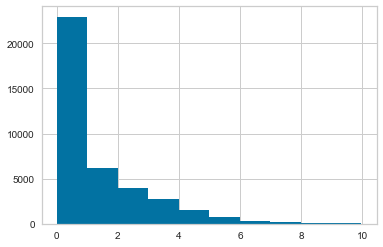

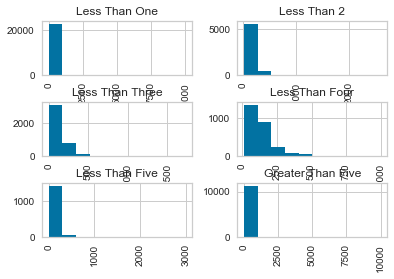

In [27]:
data[data.reviews_per_month < 10]['reviews_per_month'].hist(bins=10)
#appropriate bins are 1, 2, 3, 4, 5
data['reviews_per_month'].fillna(0, inplace=True)
data['reviews_per_month_cut'] = pd.cut(data.reviews_per_month, bins=range(0,6)
                                       , labels=['Less Than One', 'Less Than 2', 'Less Than Three', 'Less Than Four', 'Less Than Five'])
data['reviews_per_month_cut'].cat.add_categories(['Greater Than Five'], inplace=True)
data.loc[data.reviews_per_month_cut.isna(), ['reviews_per_month_cut']] = 'Greater Than Five'
data['price'].hist(by=data['reviews_per_month_cut'])

features = ['neighbourhood_group'
            , 'neighbourhood'
            , 'latitude'
            , 'longitude'
            , 'price'
            , 'minimum_nights'
            , 'number_of_reviews'
            , 'reviews_per_month'
            , 'calculated_host_listings_count'
            , 'availability_365']

target = 'room_type'
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['neighbourhood'] = data['neighbourhood'].astype('category')
data['last_review'] = pd.to_datetime(data['last_review'])
data['days_since_last_review'] = (dt.datetime.strptime('2020-01-01', '%Y-%m-%d') - data['last_review']).dt.days

data.days_since_last_review.fillna(data.days_since_last_review.max(), inplace=True) 

In [28]:
data.drop(columns=['id', 'name', 'host_id', 'host_name'], inplace=True)

In [7]:
data['price'] = data['price'].astype('float')
data['minimum_nights'] = data['minimum_nights'].astype('float')
data['number_of_reviews'] = data['number_of_reviews'].astype('float')
data['calculated_host_listings_count'] = data['calculated_host_listings_count'].astype('float')
data['availability_365'] = data['availability_365'].astype('float')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 14 columns):
neighbourhood_group               48895 non-null category
neighbourhood                     48895 non-null category
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null float64
minimum_nights                    48895 non-null float64
number_of_reviews                 48895 non-null float64
last_review                       38843 non-null datetime64[ns]
reviews_per_month                 48895 non-null float64
calculated_host_listings_count    48895 non-null float64
availability_365                  48895 non-null float64
reviews_per_month_cut             48895 non-null category
days_since_last_review            48895 non-null float64
dtypes: category(3), datetime64[ns](1), float64(9), object(1)
memory usage: 4.3+ MB


-  price: the price per night; response variable
-  latitude: locational coordinate; used by Charlie for geospatial modeling
-  longitude: locational coordinate; used by Charlie for geospatial modeling
-  minimum_nights: minimum number of nights a guest can stay for the rental


In [9]:
data_final = data
#OH encode 
label_encode = [x for x, y in dict(data_final.dtypes).items() if type(y) == pd.CategoricalDtype]
for var in label_encode:
    #impute to Mode
    print(f"{var} was OHE'd")
    data_final[var].fillna(data_final[var].mode()[0], inplace=True)
    cat_list = f'var_{var}'
    cat_list = pd.get_dummies(data[var], prefix=var)
    data_new = data_final.join(cat_list)
    data_final = data_new

normalize =  [x for x, y in dict(data_final.dtypes).items() if y == np.float64]
for col in normalize:
        #change impution scheme?
        print(f"{col} was Standard Scaled")
        data_final[col].fillna(data_final[col].median(), inplace=True)
        normalizer = StandardScaler()
        ar = data_final[col].to_numpy().reshape(-1, 1)
        normalizer.fit(ar)
        data_final.loc[:,col] = normalizer.transform(ar)

data_final.drop(columns=label_encode, inplace=True)
#data.fillna(0, inplace=True)
data_final.describe()

neighbourhood_group was OHE'd
neighbourhood was OHE'd
reviews_per_month_cut was OHE'd
latitude was Standard Scaled
longitude was Standard Scaled
price was Standard Scaled
minimum_nights was Standard Scaled
number_of_reviews was Standard Scaled
reviews_per_month was Standard Scaled
calculated_host_listings_count was Standard Scaled
availability_365 was Standard Scaled
days_since_last_review was Standard Scaled


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review,neighbourhood_group_Bronx,...,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,reviews_per_month_cut_Less Than One,reviews_per_month_cut_Less Than 2,reviews_per_month_cut_Less Than Three,reviews_per_month_cut_Less Than Four,reviews_per_month_cut_Less Than Five,reviews_per_month_cut_Greater Than Five
count,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,48895.000000,...,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,3.949141e-14,1.662286e-13,-5.581769e-16,-7.665145e-16,-2.315687e-14,4.282961e-15,3.545441e-14,1.387977e-14,5.570420e-15,0.022313,...,0.001800,0.000225,0.000020,0.004806,0.469066,0.125637,0.084630,0.053993,0.031087,0.235586
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,0.147701,...,0.042386,0.014998,0.004522,0.069161,0.499047,0.331443,0.278334,0.226007,0.173555,0.424369
min,-4.202474e+00,-6.331760e+00,-6.359342e-01,-2.939962e-01,-5.224332e-01,-6.829856e-01,-1.864514e-01,-8.568646e-01,-7.194688e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.124376e-01,-6.694733e-01,-3.486158e-01,-2.939962e-01,-4.999866e-01,-6.579428e-01,-1.864514e-01,-8.568646e-01,-7.032276e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.078110e-01,-7.605436e-02,-1.945465e-01,-1.964844e-01,-4.102001e-01,-4.513398e-01,-1.864514e-01,-5.149737e-01,-5.604755e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.265619e-01,3.443653e-01,9.277183e-02,-9.897262e-02,1.628580e-02,3.062045e-01,-1.561044e-01,8.677849e-01,3.071491e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.376357e+00,5.181954e+00,4.100441e+01,6.060212e+01,1.359649e+01,3.594209e+01,9.706672e+00,1.916250e+00,1.865454e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
data[data.price<=0]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,reviews_per_month_cut,days_since_last_review
23161,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0.0,4.0,1.0,2018-01-06,0.05,4.0,28.0,Less Than One,725.0
25433,Bronx,East Morrisania,40.83296,-73.88668,Private room,0.0,2.0,55.0,2019-06-24,2.56,4.0,127.0,Less Than Three,191.0
25634,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0.0,2.0,16.0,2019-05-18,0.71,5.0,0.0,Less Than One,228.0
25753,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0.0,2.0,12.0,2017-10-27,0.53,2.0,0.0,Less Than One,796.0
25778,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0.0,5.0,3.0,2018-01-02,0.15,1.0,73.0,Less Than One,729.0
25794,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0.0,1.0,93.0,2019-06-15,4.28,6.0,176.0,Less Than Five,200.0
25795,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0.0,1.0,95.0,2019-06-21,4.37,6.0,232.0,Less Than Five,194.0
25796,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0.0,1.0,95.0,2019-06-23,4.35,6.0,222.0,Less Than Five,192.0
26259,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0.0,3.0,0.0,NaT,0.00,1.0,0.0,Greater Than Five,3201.0
26841,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0.0,30.0,2.0,2019-06-22,0.11,6.0,333.0,Less Than One,193.0


As the dataset indicaes those apartment has recieved guests there are some cases where the price is 0. In other case sample 26259 has not yet been rentead. 

In [11]:
data_final.dtypes['availability_365']

dtype('float64')

Text(0.5, 0, 'neighbourhood group')

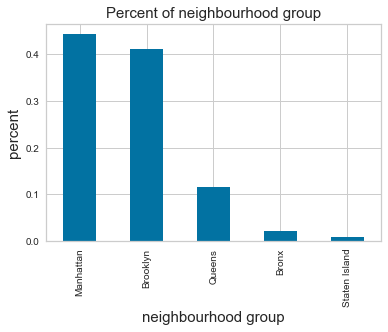

In [12]:
#visualize the categorical values for the neighbourhood_group
plt.figure(figsize=(6,4))
count_neigh = data.neighbourhood_group.value_counts()
(count_neigh/data.shape[0]).plot(kind='bar');
plt.title('Percent of neighbourhood group', fontsize = 15)
plt.ylabel('percent', fontsize = 15)
plt.xlabel('neighbourhood group', fontsize = 15)

Text(0, 0.5, 'the percent of every room type')

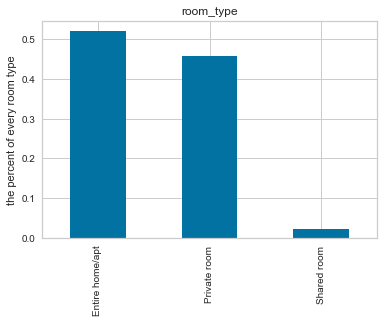

In [13]:
#visualize the categorical values for the room_type
count_room = data.room_type.value_counts()
(count_room/data.shape[0]).plot(kind='bar');
plt.title('room_type')
plt.ylabel('the percent of every room type')

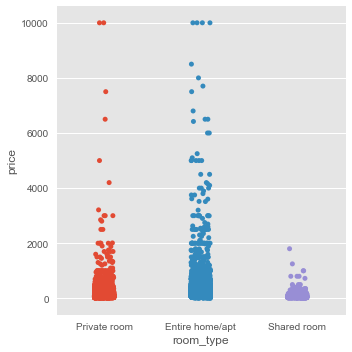

In [50]:
#catplot room type and price
sns.catplot(x="room_type", y="price", data=data);

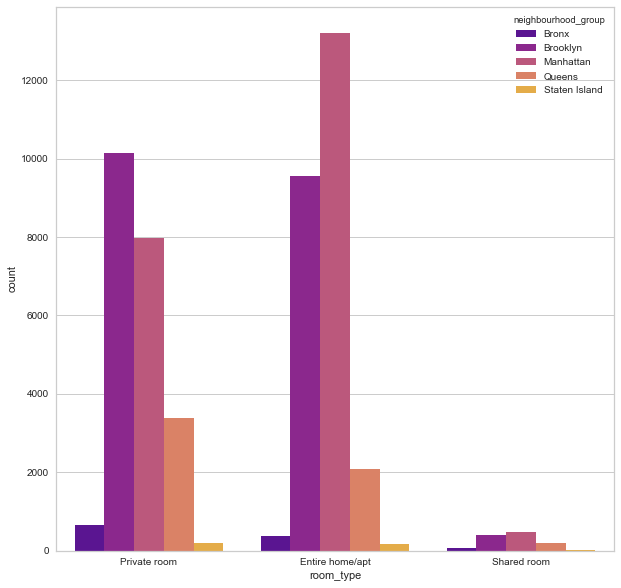

In [14]:
# create countplot roomtype and neighbourhood type
plt.figure(figsize=(10,10))
data = sns.countplot(data['room_type'],hue=data['neighbourhood_group'], palette='plasma')

### Relation between Attributes

In [21]:
data.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean()

AttributeError: 'AxesSubplot' object has no attribute 'groupby'

Text(0.5, 1.0, 'Price with regard to Neighboorhood_group')

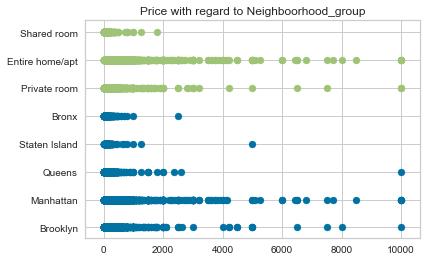

In [34]:
plt.scatter(data.price, data.neighbourhood_group)
plt.title ("Price with regard to Neighboorhood_group")

plt.scatter(data.price, data.room_type)
plt.title ("Price with regard to Neighboorhood_group")

In [45]:
def plot_property(data,title):
    all_properties=data['property_type'].tolist()
    fdist = FreqDist(all_properties)
    prop = pd.DataFrame({'Property': list(fdist.keys()),'Count': list(fdist.values())})
    prop = prop.nlargest(columns="Count", n = 10)
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)
    plt.style.use(style='ggplot')
    prop.plot(x='Property',y='Count',kind='bar',color='red')
    plt.ylabel('Frequency',fontsize=25,color='blue')
    #plt.xlabel('Amenity',fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    #plt.xlabel('Amenity',fontsize=12)
    plt.tick_params(labelsize=20)
    plt.xticks(rotation='vertical')
    plt.legend(fontsize=22)
    plt.show()

In [46]:
def plot_price_wrt_room_type(data,title):
    data2 = data.pivot(columns='room_type',values='price')
    x1=list(data2[data2.columns[0]])
    x2=list(data2[data2.columns[1]])
    x3=list(data2[data2.columns[2]])

    plt.rc('legend',**{'fontsize':25})
    #plt.legend(fontsize=20)
    plt.rcParams['figure.figsize']=(15,8)
    plt.style.use(style='ggplot')
    plt.tick_params(labelsize=25)
    plt.ylabel("Count",fontsize=25,color='blue')
    plt.xlabel("Price",fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    #plt.legend(prop={'size': 10}) 
    plt.tick_params(labelsize=25)
    n_bins=12
    colors = ['yellow', 'red', 'green']
    labels=[data2.columns[0],data2.columns[1],data2.columns[2]]
    plt.hist([x1, x2, x3], n_bins, histtype='bar', 
             color=colors, range=[0,400],label=labels,alpha=1)
         
    plt.legend(loc="upper right")
    plt.show()

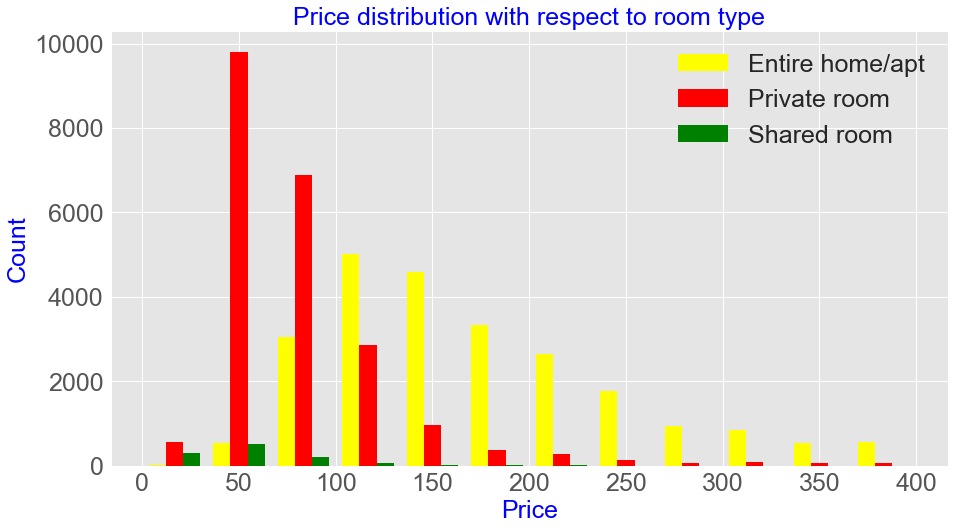

In [47]:
#df=listings
title='Price distribution with respect to room type'
plot_price_wrt_room_type(data,title)

In [49]:
# check for collinearity and visualize relationship between each predictor and price
matrix_cols = [ 'minimum_nights', 'availability_365', 'latitude', 'longitude'
               , 'number_of_reviews', 'price' ]
axs = pd.scatter_matrix(data[matrix_cols], figsize=(20, 20), c='red')

AttributeError: module 'pandas' has no attribute 'scatter_matrix'

In [22]:
data.groupby(['neighbourhood_group', 'room_type'])[['price']].mean().sort_values(['price'], ascending=False)

AttributeError: 'AxesSubplot' object has no attribute 'groupby'

In [ ]:
data.groupby("room_type")[['price','number_of_reviews']].mean()

As the data indicates, entire room or apartments cost is morethan the room and a shared room. In addition the difference in price of shared room and a ivate one is about 20 doolars. 

In [ ]:
data.groupby(['neighbourhood_group', 'room_type'])[['price']].mean().sort_values(['price'], ascending=False)

In [ ]:
for gp in set(data['neighbourhood_group']):
    print(gp)
    print(data[data['neighbourhood_group']==gp][['price','reviews_per_month']].corr())
    print()

In [ ]:
#boxplot neighbourhood_group and room availability
plt.figure(figsize=(10,10))
data = sns.boxplot(data=data, x='neighbourhood_group', y='availability_365',palette='plasma')

In [ ]:
sns.heatmap(data[['latitude','longitude','price','minimum_nights','availability_365','number_of_reviews']].corr(),annot=True)
plt.show()

# Clean

In [ ]:
# high missing values
#last_review                       10052
#reviews_per_month                 10052
